In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

insurance = pd.read_csv('./Downloads/insurance.csv')
insurance.info()
corr = insurance.corr(numeric_only=True)
print(corr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


No strong correlations so far. Though if I convert the categorical columns to numerical values that could change.

In [2]:
insurance_with_dummies = pd.get_dummies(insurance)
insurance_with_dummies.info()
insurance_with_dummies_corr = insurance_with_dummies.corr()
print(insurance_with_dummies_corr)
# print(insurance_with_dummies['smoker_yes'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   uint8  
 5   sex_male          1338 non-null   uint8  
 6   smoker_no         1338 non-null   uint8  
 7   smoker_yes        1338 non-null   uint8  
 8   region_northeast  1338 non-null   uint8  
 9   region_northwest  1338 non-null   uint8  
 10  region_southeast  1338 non-null   uint8  
 11  region_southwest  1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.4 KB
                       age       bmi  children   charges  sex_female  \
age               1.000000  0.109272  0.042469  0.299008    0.020856   
bmi               0.109272  1.

Charges correlates heavily with smoking, .787251. Although, smoking is a categorical phrasing so I guess that means the average charge is 78.7251% higher for smokers. Age at .29908 is a distant second correlate with charges. BMI .198341 is a distant third.

I noticed people in the southeast tend to have higher BMI's too. .270025 correlation.

So I guess my potentional predictors are smoker_yes, age, and bmi. 

In [3]:
print(insurance_with_dummies.describe())

               age          bmi     children       charges   sex_female  \
count  1338.000000  1338.000000  1338.000000   1338.000000  1338.000000   
mean     39.207025    30.663397     1.094918  13270.422265     0.494768   
std      14.049960     6.098187     1.205493  12110.011237     0.500160   
min      18.000000    15.960000     0.000000   1121.873900     0.000000   
25%      27.000000    26.296250     0.000000   4740.287150     0.000000   
50%      39.000000    30.400000     1.000000   9382.033000     0.000000   
75%      51.000000    34.693750     2.000000  16639.912515     1.000000   
max      64.000000    53.130000     5.000000  63770.428010     1.000000   

          sex_male    smoker_no   smoker_yes  region_northeast  \
count  1338.000000  1338.000000  1338.000000       1338.000000   
mean      0.505232     0.795217     0.204783          0.242152   
std       0.500160     0.403694     0.403694          0.428546   
min       0.000000     0.000000     0.000000          0.0000

I'm noticing that the max charge is way higher than the 75th percentile. I'm thinking it would be a good idea to check for outliers.

I also think I should keep in mind
1. doing a box-cox transformation (done)
2. ask how many variables I should use for feature selection
3. check for extreme values in charges (done)
4. consider using polynomial predictors, logarithmic predictors, splines, interaction terms or principal components

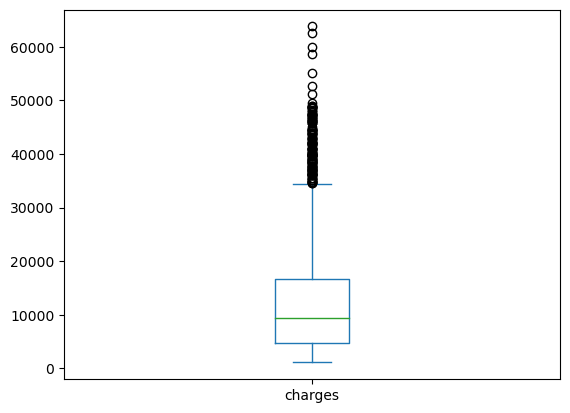

36859.4941375


In [4]:
charges = insurance_with_dummies['charges']
import matplotlib.pyplot as plt

# assuming your charges series is stored in a variable named charges
charges.plot(kind='box')
plt.show()

twenty_fifth_percentile = charges.describe()[4]
seventy_fifth_percentile = charges.describe()[6]
iqr = seventy_fifth_percentile - twenty_fifth_percentile
charges_uppper_outlier = seventy_fifth_percentile * 1.5 + iqr
print(charges_uppper_outlier)

In [5]:
charges_outliers_bool = insurance['charges'] > 36859.4941375
charges_outliers = insurance[charges_outliers_bool]
print(len(charges_outliers))

116


charges has 116 outliers.

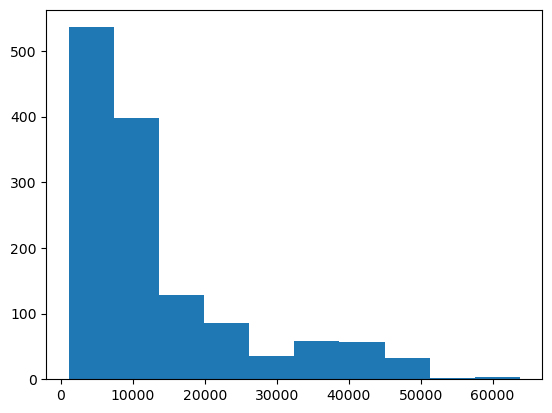

In [6]:
import matplotlib.pyplot as plt

# assuming your data is stored in a variable named my_data
plt.hist(charges)
plt.show()


Since my data is right skewed I'm going to use a box cox transformation on my outcomes. I suspect I'd be able to build a better linear model of the transformed outcomes and then I could use an inverse box cox to use that model to predict real outcomes.

Optimal value of lambda: 0.043649053770664956


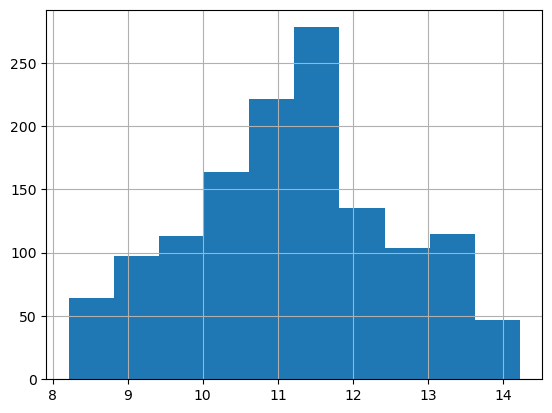

In [7]:
from scipy import stats

transformed_charges, lambda_ = stats.boxcox(charges)

print(f'Optimal value of lambda: {lambda_}')
# print(transformed_charges)

pd.Series(transformed_charges).hist()
plt.show()

It looks pretty normally distributed now!

Next I'm considering
1. How to find correlations between the predictors and transformed_charges (just add transformed_charges to insurance and plot correlations?)
2. how to choose variables for feature selection
3. consider using polynomial predictors, logarithmic predictors, splines, interaction terms or principal components

In [8]:
insurance_with_dummies['transformed_charges'] = transformed_charges
insurance_with_dummies_corr = insurance_with_dummies.corr()
print(insurance_with_dummies_corr)

                          age       bmi  children   charges  sex_female  \
age                  1.000000  0.109272  0.042469  0.299008    0.020856   
bmi                  0.109272  1.000000  0.012759  0.198341   -0.046371   
children             0.042469  0.012759  1.000000  0.067998   -0.017163   
charges              0.299008  0.198341  0.067998  1.000000   -0.057292   
sex_female           0.020856 -0.046371 -0.017163 -0.057292    1.000000   
sex_male            -0.020856  0.046371  0.017163  0.057292   -1.000000   
smoker_no            0.025019 -0.003750 -0.007673 -0.787251    0.076185   
smoker_yes          -0.025019  0.003750  0.007673  0.787251   -0.076185   
region_northeast     0.002475 -0.138156 -0.022808  0.006349    0.002425   
region_northwest    -0.000407 -0.135996  0.024806 -0.039905    0.011156   
region_southeast    -0.011642  0.270025 -0.023066  0.073982   -0.017117   
region_southwest     0.010016 -0.006205  0.021914 -0.043210    0.004184   
transformed_charges  0.51

transformed_charges biggest correlations are with 1) smoker_yes .675661 2) age at .518644 3) children .156310 4) bmi .135792

Should I include smoker_yes in the linear regression model even though it's a categorical variable? (bing says yes its common to use categorical variables in linear regression models)

Should I include children and bmi in the linear regression model? Or is the correlation low enough that including them could lead to overfitting? Is there any other reason I should or shouldn't include them in the model? (bing suggests trying models with and without them)

To create a better model, should I consider using polynomial predictors, logarithmic predictors, splines, interaction terms, principal components or any other alternatives?

After dinner I think I'll start with following the instructions and using a simple model using smoker_yes and age. I'm choosing that so I can compare future more complicated models to it to see if I'm overfitting. 

Then I think I'll create another model that uses children and bmi. Then I'll consider alternatives. 

I'm going to start by using 20% of the data as the test data. That's the general rule of thumb and my dataset doesn't seem especially small (which a larger percent for testing would be better for) or large (which a smaller percent of testing would be better for) (Not that I'm clear on what's large or small. That's my best guess.

In [9]:
X = insurance_with_dummies[['smoker_yes', 'age']]
y = insurance_with_dummies['transformed_charges']

# set the random seed to a fixed value
# np.random.seed(0) # I'm not sure this is doing anything.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)
print(X_train)

      smoker_yes  age
216            0   53
731            0   53
866            0   18
202            0   60
820            0   45
...          ...  ...
715            0   60
905            0   26
1096           1   51
235            1   40
1061           0   57

[1070 rows x 2 columns]


In [10]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_train)
# print(predictions)
coef = model.coef_
print(coef) # [2.31854023 0.05127261] 
# The coefficient for smoker_yes is much higher than age. Which I guess means that smoking is a much bigger predictor of the boxcox transformed values


[2.31854023 0.05127261]


The magnitude of the coefficients can give you an idea of the relative importance of each predictor in the model. However, it is important to note that the scale of the predictors can affect the magnitude of their coefficients. If the predictors are measured on different scales (e.g., one predictor is measured in years and another is measured in dollars), then their coefficients cannot be directly compared.

So in my case the slope is 2.31 units for someone smoking vs not smoking. While the .05 is for an additional 1 year increase in age.

In [11]:
r_squared = model.score(X_train, y_train)
print(f'R-squared: {r_squared}')

# try the r2_score function
r_two_score = r2_score(y_train, predictions)
print(r_two_score)

R-squared: 0.7398906075245502
0.7398906075245502


My r squared value indicated my model's predictor explains almost 74% of the variance in the outcomes. That sounds good but not great.

In [12]:
mse = mean_squared_error(y_train, predictions)
print(mse)

0.4805023128153892


I don't have a strong opinion of this number yet. I think I'll eventually compare this to a model that predicts the mean of the training data against the test data.

In [17]:
from scipy.special import inv_boxcox
# print(y_train.max())
# print(predictions.max())
# print(y_train.min())
# print(predictions.min())
outcomes_real_scale = inv_boxcox(y_train,lambda_)
# print(outcomes_real_scale)
predictions_real_scale = inv_boxcox(predictions,lambda_)
# print(predictions_real_scale)
mse_real_scale = mean_squared_error(outcomes_real_scale, predictions_real_scale)
print(mse_real_scale)

from scipy.special import inv_boxcox
print(inv_boxcox(mse, lambda_))

65371079.65670876
1.6088711396604742


My mean squared error on the real scale is over 65 million. This implies my model is really bad.

I'm up to step 5. I think my next step will be to go over the answer to try to figure out why their results are so much better than mine.

I confirmed that smoker_yes is equivalent to the solution's is_smoker.
I confirmed that changing the test_size from .25 to .2 doesn't make much of a difference.
I confirmed that the order of the predictors in X = insurance[["smoker_yes", "age", "bmi"]] doesn't matter at all.
I confirmed that removing bmi doesn't make much of a difference.

So is the only difference left the log scale? (The difference is that the solution inverted the log transformation of the mean squared error value while I inverted all the values of my outcomes and predictions and then got the mean squared error of those values.)

I asked this question about whether that's appropriate https://datascience.stackexchange.com/questions/122373/how-do-you-appropriately-measure-the-real-mean-squared-error-of-a-box-cox-transf

Hmm. If I log or box cox transform everything and I do what the solution does won't my mean squared error always be tiny?

"Calculate the fitted values for all of the data in the training set." - My understanding is I've already done this and I have those values stored as predictions.

"Use these calculated values to calculate the residuals of the model."

In [18]:
residuals = y_train - predictions
# print(residuals)

216    -0.046846
731    -0.089377
866    -1.399905
202    -0.062165
820    -0.126977
          ...   
715    -0.166056
905     0.132606
1096   -0.004087
235    -0.742532
1061   -0.087579
Name: transformed_charges, Length: 1070, dtype: float64


Plot the residuals against the fitted values on a graph.

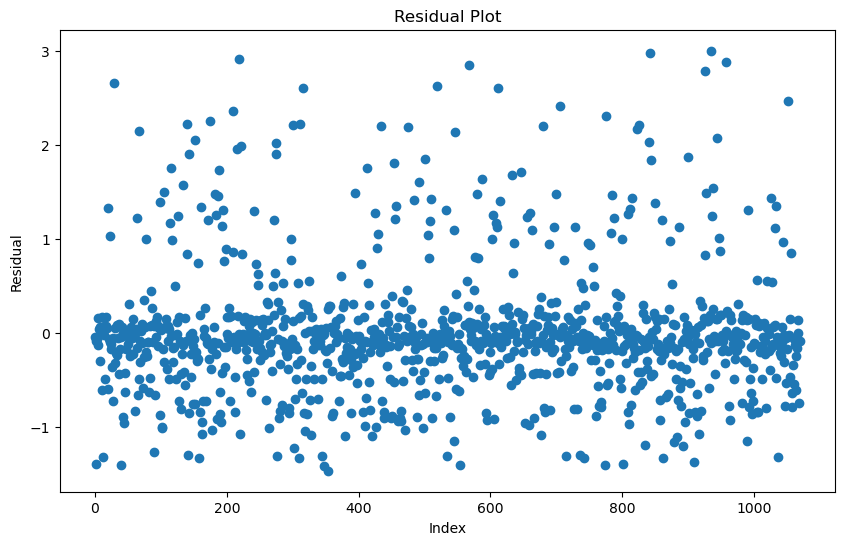

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

Do the residuals seem to center around 0 over the range of the fitted values? I wouldn't say that. There seem to be some values that are higher. And some that are a little lower.
Do the residuals seem to remain in a constant "band" around 0 over the range of fitted values? If not, what does the trend look like? Things do seem consistent. And most values are around 0. But there are some higher and lower values.
Do the residuals seem to trend with any of the predictors in the model?

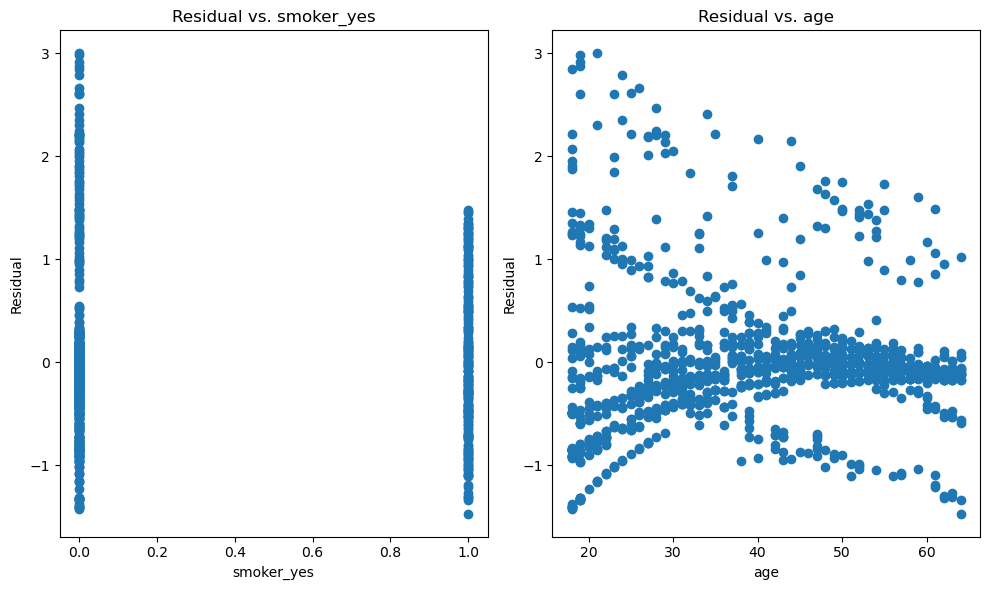

In [24]:
fig, axs = plt.subplots(1, len(X_train.columns), figsize=(10, 6))
for i, column in enumerate(X_train.columns):
    axs[i].scatter(X_train[column], residuals)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Residual')
    axs[i].set_title(f'Residual vs. {column}')
plt.tight_layout()
plt.show()

The residuals seem to trend downward as people smoke.

It's more complicated when people age. As people age there are more residuals clustered around 0, but some residuals also seem to trend downward.

"Answer each of the above questions and synthesize this information into a judgment on whether or not your model seems to agree with the model assumptions."

I'm not sure how to interpret this question. If the assumptions are stuff like the model is linear, the observations are independent, The variance of the residuals is constant across the range of the predictor variables, and The residuals are normally distributed.

I'd say maybe to the model is linear, yes to observations are independent, not sure if variance of residuals is constant across the range of predictor variables and not sure if they're normally distributed.

Check the intercept of the model.
Does it have a meaningful interpretation, given the predictors that were put in the model?
If so, how should we interpret it?

In [25]:
intercept = model.intercept_
print(intercept)

8.718581589832194


Does it have a meaningful interpretation, given the predictors that were put in the model?
If so, how should we interpret it?

For someone that's age 0 and doesn't smoke the average cost is 8.72. I don't think that's meaningful since nobody age 0 is paying for doctors visits.

For one or two predictors in the model, interpret the regression coefficient associated with it.

In [28]:
coefficients = model.coef_
print(coefficients)

print(inv_boxcox(coefficients, lambda_)) # So the cost would be 910% and 5.3% higher on the original scale?

[2.31854023 0.05127261]
[9.1027734 1.0525495]


Going from not smoking to smoking increases costs much more than a year increase in age. Should I interpret this to mean its the equivalent of 2.32/.05 years in age different? (So going from non-smoking to smoking would increase a bill as much as aging 45.22 years.) Yes according to bing who adds "this interpretation assumes that the relationship between the predictor variables and the target variable is linear and additive, as specified by the linear regression model. If this assumption is not satisfied, then this interpretation may not be valid."

And in reality going from 18-63 might increase bills a different amount than going from 45-90. It's also not clear what it means to go from non-smoking to smoking.

Take the test dataset, and use the model to produce the fitted values.

(Do I do this by running model.predict on X_test?)

In [30]:
# Make predictions for test data
test_predictions = model.predict(X_test)

# Print predictions
# print(test_predictions)

Calculate the mean squared error (MSE) of the test predictions.

In [31]:
mse = mean_squared_error(y_test, test_predictions)
print(mse)

0.47247153558434124


How does this value compare to what was calculated from the training set?

It's slightly better! So it's not overfit.

"Does the model make sense when considering its interpretation? Does it seem to match up with what you might expect?"

It seems okay. 

"Does the model seem to predict the insurance losses better? Why might this be the case, based on your model?"

better than what?

"How would you interpret the MSE for the model? If an insurance company used this model, would it be useful?"

I'm not sure how to interpret the mean squared error. I'll compare it to a baseline model to check that.

Creating a baseline model

In [34]:
training_outcome_mean = y_train.mean()
print(training_outcome_mean)

mean_predictions = np.full_like(y_test, fill_value=training_outcome_mean)

baseline_mse = mean_squared_error(y_test, mean_predictions)
print(baseline_mse)



11.19516216317598
1.942105164527195


In [36]:
test_outcomes_real_scale = inv_boxcox(y_test,lambda_)
# print(outcomes_real_scale)
baseline_predictions_real_scale = inv_boxcox(mean_predictions,lambda_)
# print(predictions_real_scale)
baseline_mse_real_scale = mean_squared_error(test_outcomes_real_scale, baseline_predictions_real_scale)
print(baseline_mse_real_scale) # 168,095,395.57556763

168095395.57556763


The mean squared error by just predicting the mean of the training data was over 168 million. So maybe my model with a score of 65 million is kind of good.

And I could also compare my model with the variance of the target variable

In [37]:
training_variance = y_train.var()
print(training_variance)

1.8490366530104552


My model’s MSE is lower than or close to the variance of the target variable. This indicates that my model is performing well because it means that, on average, your model’s predictions are closer to the actual values than the mean value of the target variable.

And residuals show that the predictions are too low when costs are higher (and they seem to show predictions are too high when costs are higher)